In [ ]:
# 2 m temperature (Mean temperature)
# Total precipitation ()
# Heavy precipitation days (Extreme rainfall)
# Warm spell duration index (Heat waves)
# Cold spell duration index (Cold waves)

In [3]:
import geopandas as gpd
import pandas as pd
from tqdm import tqdm
import numpy as np
import rasterio
import glob
import cdsapi
import xarray as xr
import rioxarray
from urllib.request import urlopen, urlretrieve
import urllib3
import os
import requests, zipfile, io
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [11]:
countries = ['Bangladesh',
             'Ethiopia',
             'Jordan',
             'Kenya',
             'Pakistan',
             'Rwanda',
             'Sudan',
             'South Sudan',
             'Tanzania',
             'Uganda']
adm0 = {}
bbox = {}
folders = next(os.walk('../data/raw/gadm'))[1]
for folder, country in zip(folders, countries):
    path = '../data/raw/gadm/' + folder
    files = glob.glob(path + "/*.shp")
    for file in files:
        if '_0.shp' in file:
            adm0[country] = gpd.read_file(file)
            bbox[country] = adm0[country].total_bounds.tolist()
adm0 = pd.concat(adm0, axis=0).reset_index(drop=True)

## ERA5
https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land-monthly-means?tab=form 

### Get data

In [6]:
countries = ['Bangladesh',
             'Ethiopia',
             'Jordan',
             'Kenya',
             'Pakistan',
             'Rwanda',
             'Sudan',
             'South Sudan',
             'Tanzania',
             'Uganda'
             ]

In [7]:
cds = cdsapi.Client()
name = 'reanalysis-era5-land-monthly-means'
download_flag = False
start = 1980
end = 2019
year = [str(i) for i in range(start, end)]
month = [str(i).zfill(2) for i in range(1, 13)]

In [8]:
for country in countries:
    # Specify the bounding box to minimize the size of the data
    box = [bbox[country][3], bbox[country][0], bbox[country][1], bbox[country][2]]

    # Setup parameters
    params = {
    "format": "netcdf",
    "product_type": "monthly_averaged_reanalysis",
    "variable": ["2m_temperature", 'total_precipitation'],
    'year': year,
    'month': month,
    "time": "00:00", 
    "grid": [0.1, 0.1],
    "area": box
    }
    
    # Get the data
    files = cds.retrieve(name, params)
    # if download_flag:
    #     fl.download("./output.nc")

    # Retrieve the data
    with urlopen(files.location) as file:
        dataset = xr.open_dataset(file.read())

    # Do masking, select only those data points that are within the country
    dataset = dataset.rio.write_crs('EPSG:4326')
    shp = adm0[adm0['NAME_0'] == country]
    clipped = dataset.rio.clip(shp.geometry.values, shp.crs)

    for t in range(len(dataset['time'])):
        # t2m first
        variable = 't2m'
        scale = lambda x: x - 273.15
        array = clipped.isel(time=t)[variable].expand_dims({"band":1})
        scale(array).fillna(0).rio.to_raster(f"../data/processed/era5/t2m/{country}{t}.tif")
        # gdf = convert_to_geodataframe(clipped)

        # now tp
        variable = 'tp'
        array = clipped.isel(time=t)[variable].expand_dims({"band":1})
        array.fillna(0).rio.to_raster(f"../data/processed/era5/tp/{country}{t}.tif")

2022-10-06 11:27:32,423 INFO Welcome to the CDS
2022-10-06 11:27:32,423 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-land-monthly-means
2022-10-06 11:27:32,571 INFO Request is completed


### Plotting

In [97]:
# variable = 'tp'
variable = 't2m'

In [98]:
array = clipped.isel(time=0)[variable].expand_dims({"band":1})

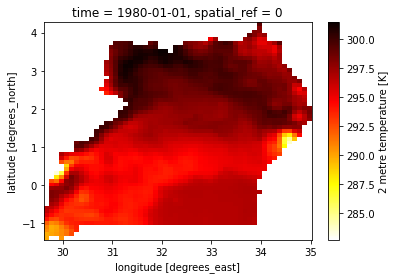

In [99]:
array.where(array >= 0).squeeze().plot.imshow(cmap="hot_r");

<AxesSubplot:>

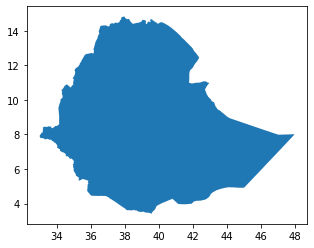

In [65]:
shp.plot()

## Agroclimatic indicators
https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-agroclimatic-indicators?tab=form

In [4]:
cds = cdsapi.Client()
name = 'sis-agroclimatic-indicators'

### Cold spell duration index, warm spell duration index

In [12]:
params = {
    "format": "zip",
    "origin": "miroc_esm_chem_model",
    "variable": ['cold_spell_duration_index', 'warm_spell_duration_index'],
    'temporal_aggregation': 'season',
    'experiment': 'historical',
    'period': '198101_201012',
    'version': '1.1',
    }

In [13]:
# Get the data
files = cds.retrieve(name, params)

2022-10-06 11:13:44,644 INFO Welcome to the CDS
2022-10-06 11:13:44,645 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/sis-agroclimatic-indicators
2022-10-06 11:13:44,707 INFO Request is queued
2022-10-06 11:13:45,763 INFO Request is completed


In [15]:
r = requests.get(files.location)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("../data/raw/agroclimatic_indicators/")

In [3]:
wsdi = xr.open_dataset("../data/raw/agroclimatic_indicators/WSDI_C3S-glob-agric_miroc-esm-chem_hist_season_19810101-20101231_v1.1.nc")
wsdi = wsdi.drop('time_bounds')
wsdi = wsdi.rio.write_crs('EPSG:4326')
csdi = xr.open_dataset("../data/raw/agroclimatic_indicators/CSDI_C3S-glob-agric_miroc-esm-chem_hist_season_19810101-20101231_v1.1.nc")
csdi = csdi.drop('time_bounds')
csdi = csdi.rio.write_crs('EPSG:4326')

In [20]:
array = clipped.isel(time=0)['CSDI'].expand_dims({"band":1})

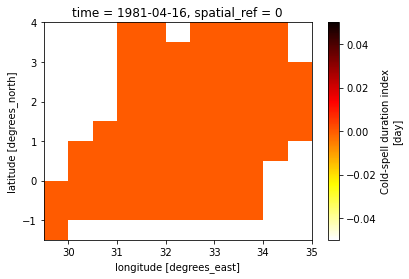

In [21]:
array.where(array >= 0).squeeze().plot.imshow(cmap="hot_r");

<AxesSubplot:>

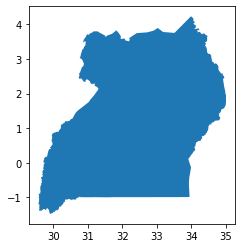

In [22]:
shp.plot()

In [29]:
countries = ['Bangladesh',
             'Ethiopia',
             'Jordan',
             'Kenya',
             'Pakistan',
             'Rwanda',
             'Sudan',
             'South Sudan',
             'Tanzania',
             'Uganda'
             ]

In [30]:
for country in tqdm(countries):
    shp = adm0[adm0['NAME_0'] == country]
    clipped = wsdi.rio.clip(shp.geometry.values, shp.crs)
    for t in range(len(clipped['time'])):
        variable = 'WSDI'
        array = clipped.isel(time=t)[variable].expand_dims({"band":1})
        array.where(array >= 0).rio.to_raster(f"../data/processed/agroclimatic_indicators/wsdi/{country}{t}.tif")
    
    clipped = csdi.rio.clip(shp.geometry.values, shp.crs)
    for t in range(len(clipped['time'])):
        variable = 'CSDI'
        array = clipped.isel(time=t)[variable].expand_dims({"band":1})
        array.where(array >= 0).rio.to_raster(f"../data/processed/agroclimatic_indicators/csdi/{country}{t}.tif")

100%|██████████| 10/10 [01:17<00:00,  7.75s/it]


### Heavy precipitation days

In [31]:
params = {
    "format": "zip",
    "origin": "miroc_esm_chem_model",
    "variable": ['heavy_precipitation_days'],
    'temporal_aggregation': '10_day',
    'experiment': 'historical',
    'period': '198101_201012',
    'version': '1.1',
    }

In [2]:
# Get the data
files = cds.retrieve(name, params)

In [87]:
r = requests.get(files.location)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("../data/raw/agroclimatic_indicators/")

In [35]:
r10mm = xr.open_dataset("../data/raw/agroclimatic_indicators/R10mm_C3S-glob-agric_miroc-esm-chem_hist_dek_19810101-20101231_v1.1.nc")
r10mm = r10mm.drop('time_bounds')
r10mm = r10mm.rio.write_crs('EPSG:4326')

In [36]:
countries = ['Bangladesh',
             'Ethiopia',
             'Jordan',
             'Kenya',
             'Pakistan',
             'Rwanda',
             'Sudan',
             'South Sudan',
             'Tanzania',
             'Uganda'
             ]

In [37]:
for country in tqdm(countries[:1]):
    shp = adm0[adm0['NAME_0'] == country]
    clipped = r10mm.rio.clip(shp.geometry.values, shp.crs)
    for t in range(len(clipped['time'])):
        variable = 'R10mm'
        array = clipped.isel(time=t)[variable].expand_dims({"band":1})
        # array.where(array >= 0).rio.to_raster(f"../data/processed/agroclimatic_indicators/r10mm/{country}{t}.tif")

100%|██████████| 1/1 [00:13<00:00, 13.47s/it]


In [58]:
len(clipped['time'])

1080

In [49]:
t = clipped['time'].values

In [57]:
pd.DataFrame(pd.to_datetime(t)).to_csv("../data/processed/agroclimatic_indicators/r10mm/t.csv", index=False)